# Tarefa 2 - Implementação de SVD e SoftImpute

Aluno: Tomás Aguiar Carneiro Ferreira

RA: 177748

In [2]:
import random
from functools import lru_cache
import os
import math
import mpmath as mp
from scipy.spatial import distance
from sklearn.impute import SimpleImputer

#Função que será utilizada para embaralhar os dados, caso necessário
from sklearn.utils import shuffle 

#Função que utilizaremos para cálculo de média
from sklearn.preprocessing import StandardScaler

import time
import numpy as np
import pandas as pd
import jax.numpy as jnp
from matplotlib import pyplot as plt
#import tensorflow as tf
#from tensorflow import keras

import sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder



# 1. Preparo dos Dados

O dataset a ser utilizado para esta tarefa consiste de amostras de 100000 ratings de 1682 filmes por 943 usuários. Como podemos ver através da análise abaixo, estes ratings são números de 1 a 5 que medem - supostamente - o quanto um determinado usuário gosta de um determinado filme.

In [3]:
#Leitura dos dados, colunas sem nome
df1 = pd.read_table('ml-100k/u.data', header = None)

#Através do 'readme' dos dados, sabemos o significado de cada coluna de u.data, então mudamos o nome para facilitar nossa compreensão
df1.columns = ['user_id', 'movie_id', 'rating', 'timestamp']

print(df1.head())
print(df1.shape)

   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
(100000, 4)


In [4]:
df1['rating'].value_counts()

4    34174
3    27145
5    21201
2    11370
1     6110
Name: rating, dtype: int64

In [5]:
sum(df1['rating'].value_counts())

100000

In [6]:
print(df1['user_id'].nunique(),df1['movie_id'].nunique())

943 1682


Nosso objetivo inicial será, então, preparar uma matriz Usuário-Filme (943 x 1682), em que interpretamos cada linha como uma amostragem de um determinado usuário aleatório e cada coluna como features do seu gosto por filme, especificada por cada filme do dataset. 

## 1.1. Montando a Matriz Usuário-Filme

A matriz de dados (100000, 4) corresponde a todos os dados não-nulos que temos a nossa disposição. No entanto, não é esta a matriz de dados que queremos tratar no projeto: queremos a matriz com <b>todas</b> as combinações possíveis de Usuário-Filme, ainda que o usuário não tenha dado nota ao filme. Inicialmente, o valor default do rating será '0', para gerarmos um plot visual dos dados.

Mais na frente, trocaremos o valor default para 'NaN', por que uma das formas que iremos preencher os dados vazios será através da média dos ratings de cada filme, e o valor 'NaN' é automaticamente desconsiderado do cálculo da média.

In [7]:
#Matriz vazia, com dimensões desejadas
null_array = [[0 for col in range(df1['movie_id'].nunique())] for row in range(df1['user_id'].nunique())]
print(np.shape(null_array))

(943, 1682)


In [8]:
#Para reduzir a complexidade das iterações 'while', vamos deixar a matriz de dados ordenada em termos do movie_id
df2 = df1.sort_values('movie_id')
df2 = df2.reset_index()

#Excluímos dados desnecessários
df1 = df1.drop(['timestamp'], axis = 'columns')
df2 = df2.drop(['index','timestamp'], axis = 'columns')
print(df2)

       user_id  movie_id  rating
0           84         1       2
1          806         1       4
2          768         1       5
3           92         1       4
4          419         1       4
...        ...       ...     ...
99995      863      1678       1
99996      863      1679       3
99997      863      1680       2
99998      896      1681       3
99999      916      1682       3

[100000 rows x 3 columns]


In [9]:
df2['movie_id'].value_counts()[1]
df2.shape[0]

100000

In [10]:
#Transforma o dataframe numa matriz de dados
start = time.perf_counter()
data_array = null_array
i = 0
buffer = 0
while i < df1.shape[0]:
    data_array[df1['user_id'].iloc[i]-1][df1['movie_id'].iloc[i]-1] = df1['rating'].iloc[i]
    i+=1
end = time.perf_counter()
print(end-start)

3.6961774000000105


In [11]:
i = 0
s = 0
while i < len(data_array):
    j = 0
    while j < len(data_array[0]):
        if data_array[i][j] != 0:
            s+=1
        j+=1
    i+=1

print(s)

100000


(0.5, 943.5)

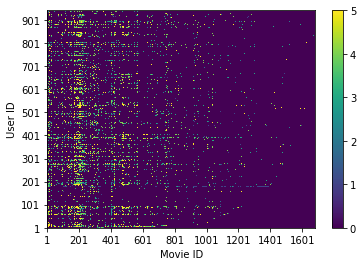

In [12]:
x = range(1682);
y = range(943);
Z = data_array;
fig, ax = plt.subplots()
contour = ax.pcolormesh(x, y, Z)

plt.xticks(np.arange(1, 1682, step=200));
plt.yticks(np.arange(1, 943, step=100));
plt.colorbar(contour)
plt.ylabel("User ID")
plt.xlabel("Movie ID")
plt.xlim(0.5, 1682.5)
plt.ylim(0.5, 943.5)

Notamos uma grande regularidade na distribuição dos ratings de acordo com o Movie ID, isto é, os filmes de menor índice tem muito mais ratings do que os de grande índice. Vamos testar a convergência do algoritmo de imputação utilizando esta matriz de dados não-embaralhada (data_array) e a embaralhada (data_rand).

In [13]:
data_rand = [shuffle(col) for col in data_array]

(0.5, 943.5)

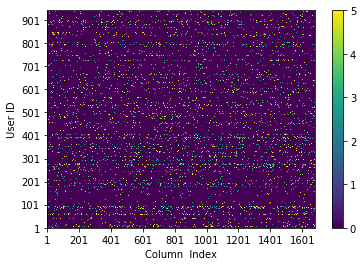

In [15]:
x = range(1682);
y = range(943);
Z = data_rand;
fig, ax = plt.subplots()
contour = ax.pcolormesh(x, y, Z)

plt.xticks(np.arange(1, 1682, step=200));
plt.yticks(np.arange(1, 943, step=100));
plt.colorbar(contour)
plt.ylabel("User ID")

#Não mais o Movie ID! Perdemos esta informação quando embaralhamos os índices dos filmes
plt.xlabel("Column  Index")
plt.xlim(0.5, 1682.5)
plt.ylim(0.5, 943.5)

## 1.2. Separação de Dados de Treino e de Teste

Como indicado anteriormente, vamos separar dados de treino e de teste através de sorteios aleatórios de tuplas de rating usuário-filme da matriz Usuário-Filme randomizada acima. Seguindo a orientação da Tarefa, vamos separar 80% dos dados para treino e 20% para teste. Como temos 100000 dados totais, isto corresponderá a 80000 dados de treino e 20000 de teste.

Um detalhe importante sobre a separação destes dados é que enquanto os dados de treino terão que estar em forma matricial para imputarmos os valores faltantes e aplicarmos o SVD, os dados de teste poderão ser descritos inteiramente em termos das tuplas de índices da matriz de dados original. Isto é, não precisamos representar os dados de teste em forma matricial.

In [16]:
#Definição das tuplas de índices das entradas não-nulas da matriz de dados não embaralhada
non_null_tuple_list = list()

#Definição das tuplas de índices das entradas não-nulas da matriz de dados embaralhada
non_null_tuple_list_rand = list()

i=0;

while i < len(data_rand):
    j=0;
    while j < len(data_rand[0]):
        buffer = [0,0]
        if data_array[i][j]!= 0.0:
            buffer[0]=i;
            buffer[1]=j;
            non_null_tuple_list.append(buffer)
        if data_rand[i][j]!= 0.0:
            buffer[0]=i;
            buffer[1]=j;
            non_null_tuple_list_rand.append(buffer)
        j+=1
    i+=1
print(len(non_null_tuple_list),len(non_null_tuple_list_rand))
print(non_null_tuple_list[-10:])

100000 100000
[[942, 942], [942, 1010], [942, 1027], [942, 1043], [942, 1046], [942, 1066], [942, 1073], [942, 1187], [942, 1227], [942, 1329]]


In [17]:
#Embaralhamento da lista de tuplas não nulas
tuple_data = shuffle(non_null_tuple_list)
tuple_data_rand = shuffle(non_null_tuple_list_rand)

#Seleção de tuplas de teste para matriz não-embaralhada
test_tuples = tuple_data[:20000];
train_tuples = tuple_data[-80000:];

#Seleção de tuplas de teste para matriz embaralhada
test_tuples_rand = tuple_data_rand[:20000];
train_tuples_rand = tuple_data_rand[-80000:];


#Exclusão das tuplas de teste da matriz de dados, gerando a matriz de treino
data_train = data_array
data_train_rand = data_array

#Como já sabemos exatamente quais as tuplas que queremos excluir do dataset original, basta zerarmos todas as entradas da matriz 'train_df' que
#correspondem às tuplas de treino
start = time.perf_counter()
for k in range(len(test_tuples)):
    data_train[test_tuples[k][0]][test_tuples[k][1]]=0.0
    data_train_rand[test_tuples_rand[k][0]][test_tuples_rand[k][1]]=0.0
end = time.perf_counter()
print(end-start)

print(len(test_tuples),len(train_tuples))
print(len(test_tuples_rand),len(train_tuples_rand))

0.027796500000022206
20000 80000
20000 80000


(0.5, 943.5)

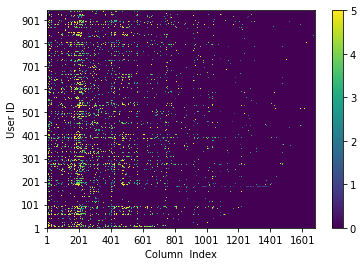

In [18]:
x = range(1682);
y = range(943);
Z = data_train;
fig, ax = plt.subplots()
contour = ax.pcolormesh(x, y, Z)

plt.xticks(np.arange(1, 1682, step=200));
plt.yticks(np.arange(1, 943, step=100));
plt.colorbar(contour)
plt.ylabel("User ID")

#Não mais o Movie ID! Perdemos esta informação quando embaralhamos os índices dos filmes
plt.xlabel("Column  Index")
plt.xlim(0.5, 1682.5)
plt.ylim(0.5, 943.5)

# 2. Implementação do SVD

Antes de prosseguirmos ao algoritmo que utilizaremos para 'adivinhar' os ratings das tuplas de teste, vamos implementar a função que servirá de base para o algoritmo: uma função que retorna a Decomposição de Valores Singulares (Single Value Decomposition ou SVD) de uma matriz. De acordo com a álgebra linear, toda matriz possui um SVD único, isto é, toda matriz pode ser decomposta na forma a seguir:

\begin{equation}
X = U \Sigma V^{T}
\end{equation}

Onde $U$ é uma matriz ortogonal de dimensões $m\times m$, $\Sigma$ é uma matriz quase diagonal de dimensões $m \times n$ matrix e $V$ é uma matriz ortogonal de dimensões $n\times n$. A interpretação geométrica desta decomposição é de que o efeito da aplicação da matriz $X$ sobre qualquer vetor do espaço $\mathbb{R}^n$ é idêntico a aplicar uma rotação (matriz $V^T$) seguida de uma 'distensão' ou 'compressão' (matriz $\Sigma$), que por sua vez é seguida por uma última rotação (matriz $U^T$).

Se $m>n$, então a matriz de covariância de interesse - aquela com as maiores dimensões - é determinada através da expressão $C=X^T X\in \mathbb{R^{n\times n}}$. Este procedimento é necessário para que consigamos determinar os autovetores relacionados aos autovalores nulos também (autovetors do núcleo de $C$, ou $\text{ker}(C)$). Dado que a matriz $C$ é simétrica positiva semi-definida, pode ser decomposta utilizando as funções de autovalores e autovetores na seguinte forma:

\begin{equation*}
    C= PDP^T
\end{equation*}

Onde $D$ é uma matriz diagonal $n\times n$ e $P$ uma matriz ortogonal $n\times n$. Vamos verificar suas relações com as matrizes da decomposição de $X$. 

\begin{equation}
    C=X^TX=(V\Sigma^T U^T)(U\Sigma V^T)=V(\Sigma^T\Sigma) V^T
\end{equation}

Notamos que, da nossa definição de $\Sigma$, a matriz $\Sigma^T\Sigma$ será uma matriz diagonal de dimensões $n\times n$. Identificamos, então, esta matriz como sendo a matriz $D$ da decomposição anterior. Além disso, $V$ será igual à matriz $P$. Em outras palavras, $V$ é nada mais do que a matriz cujas colunas são os autovetores da matriz de covariância $C$. Tendo encontrado $V$, podemos obter a matriz $U$. Começando pela matriz $X$:

\begin{align*}
    X=U\Sigma V^T \Rightarrow XV&=U\Sigma V^TV=U\Sigma
\end{align*}

Explicitando a multiplicação matricial em termos de entradas de matriz, temos:

\begin{align*}
    &(U\Sigma )_{ij}=\sum_{p=1}^{m}u_{ip}\sigma_{pj}\delta_{pj}=\sigma_j u_{ij}\\
    &(XV)_{ij}=\sum_{s=1}^{m}x_{is}v_{sj}=\boldsymbol{x}_i\boldsymbol{v}_j^T
\end{align*}

\begin{equation*}
    \Rightarrow u_{ij}=\frac{1}{\sigma_j}\boldsymbol{x}_i\boldsymbol{v}_j^T
\end{equation*}

Onde entendemos que $\boldsymbol{x}_i$ é a $i$-ésima linha da matriz $X$ e $\boldsymbol{v}_j$ a $j$-ésima linha da matriz $V$. O motivo pelo qual representamos em termos de linhas ao invés de colunas é para estabelecermos um paralelo mais claro com a implementação do SVD. Feito isso para todos os índices, temos a decomposição SVD. Para o caso em que $m>n$, o procedimento é análogo, trocando-se a definição da matriz de covariância para $XX^T$, o que faz com que troquemos os passos considerando  $U,u$ no lugar de $V,v$. Além disso, no último passo:

\begin{align*}
    X=U\Sigma V^T \Rightarrow U^TX&=\Sigma V^T\Rightarrow X^TU=V\Sigma
\end{align*}
Por último, o motivo que separamos o caso $m=n$ é que quando a matriz é quadrada as matrizes singulares da esquerda e direita serão iguais $U=V$.

O nosso dataset (matriz $X$) é uma matriz $943\times 1682$, então o posto será $m=943$. Assim, precisamos adicionar $n-m$ vetores ortonormais os quais são ortogonais a todos os autovetores $m$ e os quais tem autovalor nulo (são vetores do $\text{ker}(C)$).

\begin{equation*}
C\boldsymbol{v}_j = \lambda_j \boldsymbol{v}_j,\;\;\; j \in \left\{1,2,...,m \right\}
\end{equation*}
\begin{equation*}
C\boldsymbol{v}_j = \mathbb{0},\;\;\; j \in \left\{m+1, m+2,...,n \right\}
\end{equation*}
\begin{equation*}
\boldsymbol{v}_k \boldsymbol{v}_l^T=\delta_{kl}, \;\;\; k,l \in \left\{1,2,...,n \right\}
\end{equation*}


Reiteramos que, na nossa convenção, os vetores $\boldsymbol{v}_i$ são <b>vetores-linha</b>. Com este esclarecimento, podemos seguir para a implementação.

In [19]:
A=[[3,2,2],[1,4,2],[1,1,3]]
B = [[3,2,2],[1,4,2]]

#Função que computa os autovalores e autovetores de uma matriz hermitiana em ordem ascendente de autovalor
def asc_eigenh(X):
    eigenValues, eigenVectors = np.linalg.eigh(X)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors)

#Função que computa os autovalores e autovetores de uma matriz hermitiana em ordem descendente de autovalor
def desc_eigenh(X):
    eigenValues, eigenVectors = np.linalg.eigh(X)
    idx = np.argsort(eigenValues)[::-1][:len(eigenValues)]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors)

print(asc_eigen(A))
print(desc_eigen(A)[1])

(array([1.76393202, 2.        , 6.23606798]), array([[ 4.65341127e-01, -3.88578059e-16,  6.47936163e-01],
       [ 4.65341127e-01, -7.07106781e-01,  6.47936163e-01],
       [-7.52937760e-01,  7.07106781e-01,  4.00446571e-01]]))
[[ 6.47936163e-01 -3.88578059e-16  4.65341127e-01]
 [ 6.47936163e-01 -7.07106781e-01  4.65341127e-01]
 [ 4.00446571e-01  7.07106781e-01 -7.52937760e-01]]


In [20]:
#Implementação do SVD
def SVD(data):

    #Transforma pd.DataFrame em matriz do numpy
    data_buff = np.array(data)

    #Vetor do SVD
    SVD_array = [0,0,0]

    #Se a matriz de dados for quadrada. Basicamente os mesmos passos das outras, pulando-se o cálculo de uma das matrizes U ou V
    if len(data_buff)==len(data_buff[0]):

        #Guarda o posto da matriz de dados
        rk = len(data_buff)
        
        #Calcula a matriz de covariância
        cov_data = np.matmul(data_buff.transpose(),data_buff)
    
        #Calcular os autovalores e autovetores da matriz de covoariância
        SVD_buff = desc_eigenh(cov_data)

        #Seguindo a análise anterior, a matriz sigma e a matriz singular da direita, V corresponderão às primeiras 'rk' (posto) entradas do resultado da
        #decomposição em autovalores.

        #Matriz Sigma,lembrando que os valores singulares são a raiz quadrada dos autovalores da matriz de covariância
        SVD_array[1] = np.sqrt(abs(SVD_buff[0][:rk]))

        #Matriz V. Para selecionar as 'rk' primeiras colunas, precisamos primeiramente transpor 
        SVD_array[2] =SVD_buff[1]
        
        #Matriz U
        SVD_array[0] = SVD_buff[1]


    #Se a matriz de dados tiver mais colunas do que linhas
    if len(data_buff)<len(data_buff[0]):

        #Guarda o posto da matriz de dados
        rk = len(data_buff)
        
        #Calcula a matriz de covariância
        cov_data = np.matmul(data_buff.transpose(),data_buff)
    
        #Calcular os autovalores e autovetores da matriz de covoariância
        SVD_buff = desc_eigenh(cov_data)

        #Seguindo a análise anterior, a matriz sigma e a matriz singular da direita, V corresponderão às primeiras 'rk' (posto) entradas do resultado da
        #decomposição em autovalores.

        #Matriz Sigma,lembrando que os valores singulares são a raiz quadrada dos autovalores da matriz de covariância
        SVD_array[1] = np.sqrt(abs(SVD_buff[0][:rk]))

        #Matriz V. Para selecionar as 'rk' primeiras colunas, precisamos primeiramente transpor 
        SVD_array[2] = SVD_buff[1]

        #Cálculo da matriz U

        #U_buff seria a matriz U multiplicada pela direita por Sigma
        U_buff = np.matmul(data_buff, SVD_array[2])

        #Re-escalo cada linha de U pelos respectivos valores singulares
        i=0
        while i < len(U_buff):
            U_buff[i]=U_buff[i]/(SVD_array[1][i])
            i+=1

        #Matriz U
        SVD_array[0] = U_buff
    
    #Se a matriz de dados tiver mais linhas do que colunas   
    if len(data_buff)>len(data_buff[0]):
    
        #Guarda o posto da matriz de dados
        rk = len(data_buff[0])

        #Guardo a matriz de dados transposta porque mais à frente vou utilizar para obter a matriz singular da direita V
        data_trsp = data_buff.transpose()
        
        #Calcula a matriz de covariância, com a matriz transposta multiplicando pela direita
        cov_data = np.matmul(data_buff,data_trsp)
    
        #Calcular os autovalores e autovetores da matriz de covoariância
        SVD_buff = desc_eigenh(cov_data)

        #Seguindo a análise anterior, a matriz sigma e a matriz singular da esquerdaa, U corresponderão às primeiras 'rk' (posto) entradas do resultado
        #da decomposição em autovalores.

        #Matriz U. Para selecionar as 'rk' primeiras colunas, precisamos primeiramente transpor 
        SVD_array[2] = SVD_buff[1]
    
        #Matriz Sigma,lembrando que os valores singulares são a raiz quadrada dos autovalores da matriz de covariância
        SVD_array[1] = np.sqrt(SVD_buff[0][:rk])
   
        #Cálculo da matriz U

        #V_buff seria a matriz V multiplicada pela direita por Sigma
        V_buff = np.matmul(data_trsp, SVD_array[2])

        #Re-escalo cada linha de U pelos respectivos valores singulares
        i=0
        while i < len(V_buff):
            V_buff[i]=V_buff[i]/(SVD_array[1][i])
            i+=1

        #Matriz V
        SVD_array[2] = V_buff

    return SVD_array

In [21]:
start = time.perf_counter()
train_SVD = SVD(data_train)
end= time.perf_counter()
print(end-start)

start = time.perf_counter()
train_SVD_rand = SVD(data_train_rand)
end= time.perf_counter()
print(end-start)

1.461849500000028
1.5175959000000034


# 3. Imputação de Valores Nulos: <i>Soft Impute</i>

O método de imputação que vamos utilizar para preencher os valores vazios da matriz de dados será aquele contido no início do artigo do Hastie: o <i> soft impute</i>. A forma que o algoritmo funciona é da seguinte maneira.

Considere uma matriz de dados <i>esparsa</i> $X$, ou seja, que possui praticamente todas as suas entradas faltantes (na nossa matriz de treino, apenas $5\%$ das entradas são conhecidas, o que nos põe neste regime). Para inicializar o método, substituímos todos os valores desconhecidos pelo valor médio de $X$, coluna a coluna, o qual denominamos $\bar{x}$. Isto nos dá a matriz imputada $\tilde{X}$. Note que nós também testamos o algoritmo para a imputação nula, que corresponderia a $\bar{x}=0$ para todas as colunas.

1. Primeiramente, calculamos o SVD da matriz imputada $\tilde{X}$. Como apontado anteriormente na nossa implementação do SVD, a matriz utilizada para extrair as componentes principais da matriz de dados é a matriz $V$.

\begin{equation*}
\tilde{X}=U\Sigma V^T
\end{equation*}
 

2. Definimos a função objetiva $\phi(x_{ij})$, em que $x_{ij}$ são os elementos conhecidos da matriz $X$.
   \begin{equation*}
   \phi(x_{ij})=\sum_{(i,j) \in \mathcal{O}} \left(x_{ij}-\sum_{m=1}^{M}  \tilde{X}_{im} V_{mj}\right)^2
   \end{equation*}
   Em que $\mathcal{O}$ é o conjunto de tuplas conhecidas e o somatório de $1$ até $M$ é sobre as componentes principais da matriz imputada $\tilde{X}$, sendo $V$ a matriz que multiplica o lado direito da matriz de autovalores $\Sigma$. Se estamos no primeiro estágio, computamos e guardamos este valor. Caso seja algum estágio intermediário, computamos a diferença entre a nova função objetiva e a função objetiva do estágio anterior. Se a variação desta função estiver abaixo de uma certa tolerância (espera-se que esta função tenda a um mínimo), a rotina é interrompida e a matriz imputada terá convergido.

   
3. Substituo todos os elementos imputados no estágio anterior (se é o primeiro estágio após a inicialização, substituo todos os valores médios imputados inicialmente $\bar{x}$)  pelos elementos correspondentes aos da matriz de componentes principais.
   \begin{equation*}
   \bar{x}_{ij}\rightarrow \sum_{(i,j) \notin \mathcal{O}} \left(\sum_{m=1}^{M} \tilde{X}_{im} V_{mj}\right)
   \end{equation*}
   Onde ressaltamos que $\mathcal{O}$ é o conjunto de tuplas conhecidas: o somatório acima é sobre todas as tuplas desconhecidas. Uma outra forma de entender este passo é a partir das duas seguintes equações:
\begin{align*}
   &\tilde{X}_{ij} = X_{ij},\;\;\;\; (i,j) \in \mathcal{O}\\
&\tilde{X}_{ij}=\left(\sum_{m=1}^{M} \tilde{X}_{im} V_{mj}\right),\;\;\;\; (i,j)\notin \mathcal{O}
   \end{align*}

4. Repetir os passos anteriores até a função objetiva estar abaixo da tolerância.


O motivo preciso de por que este algoritmo funciona não é algo que domino. Do pouco que pude acumular baseado no artigo do Hastie e do vídeo no YouTube onde ele explica o Soft Impute (URL=https://www.youtube.com/watch?v=MYKb5KcI55s), a aplicação deste algoritmo - pelo menos em casos mais complexos comparados a esta Tarefa - se dá em termos de três características do nosso dataset.

Primeiro, que existem correlações entre o gosto de filme dos usuários: no problema original que inspirou o algoritmo (competição da Netflix), o número de usuários era tão grande ( $\sim 400000$) que esperava-se amostragens repetidas de usuários típicos com gostos parecidos de filme. No nosso dataset, temos apenas $943$ usuários, mas como vimos da depicção visual do dataset, nos parece razoável assumir que há mesmo correlações em gosto de filme.

Segundo, que os valores faltantes são aleatórios. Ou seja, como se tivessem sidos 'removidos às cegas'.

A terceira característica é que estamos tratando de matrizes esparsas. Apesar disto não ter impacto na implementação contida nesta Tarefa, no problema da Netflix a matriz possuía dimensões $\sim 20000 \times 400000$, o que significa que havia um grande desafio para o armazenamento de dados na aplicação do SVD nos estágios intermediários. Dado o fato das matrizes serem esparsas (quase todas as entradas são desconhecidas) pode-se explorar métodos de representação que reduzem drasticamente a alocação de memória em cada passo do algoritmo. Porém, desconheço os detalhes e não saberia implementá-los aqui.

Finalmente, um detalhe muito importante que foi omitido até agora é que o número de componentes principais a ser utilizado $M$ não deve ser escolhido arbitrariamente. Isto é, existem valores de $M$ que aceleram a convergência e a precisão do algoritmo proposto. No entanto, até onde pude ver, não existe uma forma analítica de encontrar este valor: testamos diferentes valores de $M$ através de tentativa e erro. 

A otimização deste parâmetro será dada através de 2 gráficos, cujos eixos horizontais serão todos diferentes valores de $M$: plotaremos gráficos em que o eixo vertical é precisão e tempo de execução até convergência.

Visto que esta parte da rotina requer muitas iterações do SVD, decidimos utilizar a implementação do numpy em função de sua eficiência esperada. Após escolhermos algum valor de $M$ baseado na análise desta seção, iremos utilizar a nossa implementação de SVD para rodar o algoritmo.

## 3.1. Algoritmo

Para simular matrizes de dados com valores faltantes, redefinimos os valors nulos da seção anterior de volta a np.nan.

In [22]:
#Substitui valores nulos por np.nan
data_nan = data_train
data_nan_rand = data_train_rand

i=0;
start = time.perf_counter()
while i < len(data_train):
    j=0;
    while j < len(data_train[0]):
        if data_train[i][j]== 0.0:
            data_nan[i][j]=np.nan
        if data_train_rand[i][j]== 0.0:
            data_nan_rand[i][j]=np.nan
        j+=1
    i+=1
end = time.perf_counter()
print(end-start)

1.5762664999999743


### Visualização da Imputação Média e do PCA

Antes de definir e aplicar o SoftImpute, decidimos visualizar o primeiro passo pós imputação média (ou nula). Isto é, visualizaremos o PCA da matriz imputada, utilizando a função SVD que implementamos.

In [23]:
#Para calcular a média de cada coluna, vamos converter para um pd.DataFrame
df_nan = pd.DataFrame(data_nan)
df_nan_rand = pd.DataFrame(data_nan_rand)

#Cálculo das médias
column_means = df_nan.mean()
column_means_rand = df_nan_rand.mean()

#Se a coluna é completamente nan, preencher com a média global
global_mean = df_nan.stack().mean()
global_mean_rand = df_nan_rand.stack().mean() 

#Imputação média condicional
df_med_imp = df_nan.apply(lambda col: col.fillna(column_means[col.name] if not np.isnan(column_means[col.name]) else global_mean))
df_med_imp_rand = df_nan_rand.apply(lambda col: col.fillna(column_means_rand[col.name] if not np.isnan(column_means_rand[col.name]) else global_mean_rand))

#Converto de volta pra array
data_med_imp = np.array(df_med_imp)
data_med_imp_rand = np.array(df_med_imp_rand)

### Matriz não-embaralhada

(0.5, 943.5)

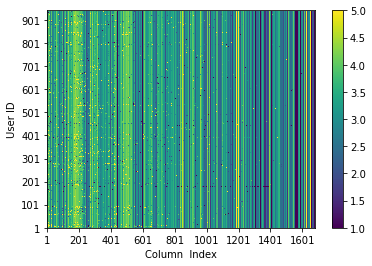

In [26]:
x = range(len(data_med_imp[0]));
y = range(943);
Z = data_med_imp;
fig, ax = plt.subplots()
contour = ax.pcolormesh(x, y, Z)

plt.xticks(np.arange(1, len(data_med_imp[0]), step=200));
plt.yticks(np.arange(1, 943, step=100));
plt.colorbar(contour)
plt.ylabel("User ID")

#Não mais o Movie ID! Perdemos esta informação quando embaralhamos os índices dos filmes
plt.xlabel("Column  Index")
plt.xlim(0.5, len(data_med_imp[0])-0.5)
plt.ylim(0.5, 943.5)

### Matriz embaralhada

1.4261314999999968


(0.5, 943.5)

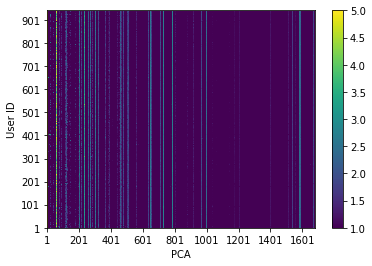

In [36]:
#PCA da matriz imputada inicial
s = 500
start = time.perf_counter()
data_mean_trsp = data_med_imp.transpose()
data_mean_PCA_s= np.matmul(data_mean_trsp[:s].transpose(), SVD(data_med_imp)[2][:s])
data_mean_PCA_s_clip = np.clip(data_mean_PCA_s, 1, 5)
end = time.perf_counter()
print(end-start)

x = range(len(data_med_imp[0]));
y = range(943);
Z = data_mean_PCA_s_clip;
fig, ax = plt.subplots()
contour = ax.pcolormesh(x, y, Z)

plt.xticks(np.arange(1, len(data_med_imp[0]), step=round(200)));
plt.yticks(np.arange(1, 943, step=100));
plt.colorbar(contour)
plt.ylabel("User ID")

#Não mais o Movie ID! Perdemos esta informação quando embaralhamos os índices dos filmes
plt.xlabel("PCA")
plt.xlim(0.5, len(data_med_imp[0])-0.5)
plt.ylim(0.5, 943.5)

1.4088928000001033


(0.5, 943.5)

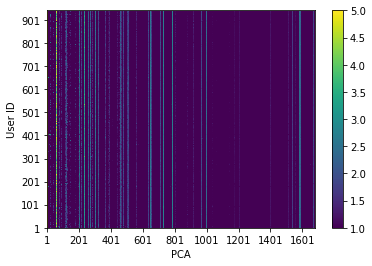

In [37]:
#PCA da matriz imputada inicial
s = 500
start = time.perf_counter()
data_mean_trsp = data_med_imp_rand.transpose()
data_mean_PCA_s= np.matmul(data_mean_trsp[:s].transpose(), SVD(data_med_imp_rand)[2][:s])
data_mean_PCA_s_clip = np.clip(data_mean_PCA_s, 1, 5)
end = time.perf_counter()
print(end-start)

x = range(len(data_med_imp_rand[0]));
y = range(943);
Z = data_mean_PCA_s_clip;
fig, ax = plt.subplots()
contour = ax.pcolormesh(x, y, Z)

plt.xticks(np.arange(1, len(data_med_imp_rand[0]), step=round(200)));
plt.yticks(np.arange(1, 943, step=100));
plt.colorbar(contour)
plt.ylabel("User ID")

#Não mais o Movie ID! Perdemos esta informação quando embaralhamos os índices dos filmes
plt.xlabel("PCA")
plt.xlim(0.5, len(data_med_imp_rand[0])-0.5)
plt.ylim(0.5, 943.5)

(0.5, 943.5)

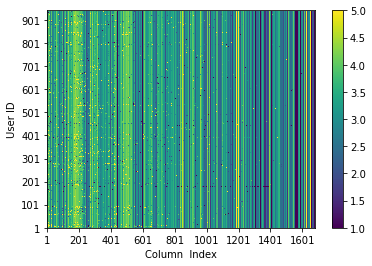

In [33]:
x = range(len(data_med_imp_rand[0]));
y = range(943);
Z = data_med_imp;
fig, ax = plt.subplots()
contour = ax.pcolormesh(x, y, Z)

plt.xticks(np.arange(1, len(data_med_imp_rand[0]), step=200));
plt.yticks(np.arange(1, 943, step=100));
plt.colorbar(contour)
plt.ylabel("User ID")

#Não mais o Movie ID! Perdemos esta informação quando embaralhamos os índices dos filmes
plt.xlabel("Column  Index")
plt.xlim(0.5, len(data_med_imp_rand[0])-0.5)
plt.ylim(0.5, 943.5)

Feito este teste preliminar, iremos implementar de fato o SoftImpute, utilizando o SVD do Numpy.

### Função Objetiva e teste rápido

A função objetiva será basicamente um cálculo da distância Euclidiana entre as tuplas conhecidas e as imputadas.

In [42]:
#Função objetiva. A entrada 'key' é a lista de tuplas conhecidas
def SoftIMP_obj(data, imp, key):
    #Como a função objetiva é apenas uma comparação entre os 80000 valores conhecidos e os valores imputados, não precisamos iterar sobre todos os
    #elementos da matriz, apenas sobre as tuplas contidas na 'key'
    data_list = list()
    imp_list = list()
    data_buff = np.array(data)
    imp_buff = np.array(imp)
    i=0;
    while i < len(key):
        if key[i][1] < len(data_buff[0]):
            data_list.append(data_buff[key[i][0]][key[i][1]]);
            imp_list.append(imp_buff[key[i][0]][key[i][1]]);
        i+=1

    #Calculo a distância Euclidiana entre a lista de ratings conhecidos e a lista de ratings imputados
    dist = distance.euclidean(data_list,imp_list)

    return dist

In [43]:
#Matriz de dados
A = [[1,np.nan],[np.nan,2]]

#Matriz imputada
B = [[4,1],[1,6]]

#'key' -> Posições da matriz de dados onde existem valores conhecidos
K = [[0,0],[1,1]]

start = time.perf_counter()
print(SoftIMP_obj(A, B, K))
end = time.perf_counter()
print(end-start)

5.0
0.0005772000000661137


### Função de Imputação

Durante a implementação do passo inicial como sendo a imputação média, tive problemas para manter as colunas vazias da matriz. Como acabei resolvendo este problema muito tarde (a solução está no passo onde visualizamos o PCA), ao invés de incluir este passo de inicialização, decidi simplesmente utilizar a implementação abaixo e passar a matriz já imputada com os valores médios direto na matriz, que resulta no mesmo procedimento descrito no cabeçalho da seção.

In [107]:
#Função de imputação. 'm' é o número de componentes principais e 'dec' é o número de casas decimais de tolerância que queremos impor. Por exemplo,
#tol = 5 será equivalente a uma tolerância de 10^-5 sob a condição de convergência
def SoftIMP_np(data, key, m, dec):

    #Transforma dados em array do numpy
    data_buff = np.array(data)

    #Converte valores np.nan vazios em 0.0
    i = 0
    while i < len(data):
            j=0;
            while j < len(data_buff[0]):
                if np.isnan(data_buff[i][j]):
                    data_buff[i][j] = 0.0
                j+=1
            i+=1

    data_imp_old = data_buff
    
    #Definição da tolerância de convergência
    tol =0.1 ** dec
    
    #Parte iterativa do algoritmo, calculando o valor inicial da objetiva
    obj_old = 0.0
    obj_new = 1.0
    while abs(obj_new - obj_old) > tol:

        #Atualiza o valor da objetiva antiga pela nova do passo anterior
        obj_old = obj_new
        
        #Calcula a matriz de covariância da matriz imputada
        cov_data = np.matmul(data_imp_old.transpose(),data_imp_old)
    
        #Calcula o SVD da matriz de covariância
        cov_data_svd = np.linalg.svd(cov_data)
        
        #Na definição do numpy, a entrada [2] do svd nos dá a hermitiana conjugada (no nosso caso, a matriz V transposta). Para a projeção de
        #componentes principais, precisamos da matriz V não-transposta
        V_matrix= cov_data_svd[2].transpose()
    
        #Para o cálculo dos novos valores imputados, multiplicamos as M primeiras colunas linha da matriz imputada às M primeiras linhas da matriz V 
        #do SVD
        data_trsp = data_imp_old.transpose()
        data_trsp_m = data_trsp[:m]
        data_orig_m = data_trsp_m.transpose()
        V_matrix_m = V_matrix[:m]
        data_imp_new = np.matmul(data_orig_m, V_matrix_m)

        #Teste de convergência para a nova matriz imputada
        obj_new = SoftIMP_obj(data_imp_old, data_imp_new, key)
        
        #Como nos estágios intermediários, a matriz de ratings passa a ter valores imputados fora do intervalo 1 e 5, precisamos retornar as entradas
        #ao intervalo 1 e 5
        data_imp_new_clip = np.clip(data_imp_new, 1, 5)
        data_imp_new = data_imp_new_clip        
        
        #Substituo os valores conhecidos de volta à matriz imputada
        i = 0
        while i < len(key):
           data_imp_new[key[i][0]][key[i][1]] = data_buff[key[i][0]][key[i][1]]
           i+=1

        #Atualizo a matriz antiga para a nova
        data_imp_old = data_imp_new

    #Após convergir, converte entradas para o inteiro mais próximo
    k = 0
    while k < len(data_imp_new):
        l = 0
        while l < len(data_imp_new[0]):
            data_imp_new[k][l] = round(data_imp_new[k][l])*1.0
            l+=1
        k+=1           
    
    data_imp_new_clip = np.clip(data_imp_new, 1, 5)
    return data_imp_new_clip

Além do algoritmo do SoftImpute, definimos a função que será utilizada para realizar o teste de acurácia.

In [50]:
#Teste de acurácia a ser utilizado 
def acc_test(data, imp_data, test_key):
    acc_list = list()
    i = 0;
    while i < len(test_key):
        boolean = int(imp_data[test_key[i][0]][test_key[i][1]]==data[test_key[i][0]][test_key[i][1]])
        acc_list.append(boolean)
        i+=1
    acc =100*sum(acc_list)/len(acc_list)
    return acc

Também simulamos matrizes de dados com valores faltantes np.nan.

In [51]:
#Substitui valores nulos por np.nan
full_data_nan = data_array
data_nan = data_train
i=0;
start = time.perf_counter()
while i < len(data_array):
    j=0;
    while j < len(data_array[0]):
        if data_train[i][j]== 0.0:
            data_nan[i][j]=np.nan
        j+=1
    i+=1
end = time.perf_counter()
print(end-start)

0.8469314000000168


### Comparação entre Matriz de dados com colunas embaralhadas e não-embaralhadas

In [57]:
M = 10
start = time.perf_counter()
data_soft_imp = SoftIMP_np(data_med_imp, train_tuples, M, 1);
end = time.perf_counter()
print(end-start)

186.66828940000005


In [58]:
M = 10
start = time.perf_counter()
data_soft_imp_rand = SoftIMP_np(data_med_imp_rand, train_tuples_rand, M, 1);
end = time.perf_counter()
print(end-start)

20.741908700000067


In [59]:
print(acc_test(data_array, data_soft_imp, test_tuples))

print(acc_test(data_rand, data_soft_imp_rand, test_tuples_rand))

0.0
5.925


Para $M=10$, notamos uma clara melhoria na acurácia e tempo de execução para os dados de treino embaralhados. Por este motivo, abandonaremos os dados de treino não-embaralhados e centraremos a nossa análise nos dados embaralhados. Antes de montar um gráfico de acurácia por $M$, testamos vários valores abaixo.

### Testes com inicialização média

In [108]:
M = 1
start = time.perf_counter()
data_med_imp_rand = SoftIMP_np(data_med_imp_rand, train_tuples_rand, M, 1);
print(acc_test(data_rand, data_soft_imp_rand, test_tuples_rand))
end = time.perf_counter()
print(end-start)

5.925
13.90215309999985


In [61]:
M = 10
start = time.perf_counter()
data_med_imp_rand = SoftIMP_np(data_med_imp_rand, train_tuples_rand, M, 1);
print(acc_test(data_rand, data_soft_imp_rand, test_tuples_rand))
end = time.perf_counter()
print(end-start)

5.925
87.98849470000005


In [62]:
M = 20
start = time.perf_counter()
data_med_imp_rand = SoftIMP_np(data_med_imp_rand, train_tuples_rand, M, 1);
print(acc_test(data_rand, data_soft_imp_rand, test_tuples_rand))
end = time.perf_counter()
print(end-start)

5.925
17.63029759999995


In [63]:
M = 100
start = time.perf_counter()
data_med_imp_rand = SoftIMP_np(data_med_imp_rand, train_tuples_rand, M, 1);
print(acc_test(data_rand, data_soft_imp_rand, test_tuples_rand))
end = time.perf_counter()
print(end-start)

5.925
88.41293610000002


À medida que $M$ aumenta bastante, o tempo de execução não só piora, mas a acurácia também. Por este motivo, centraremos nossa análise em valores de $M$ entre $1$ e $100$.

In [68]:
M = 1
start = time.perf_counter()
data_med_imp_rand = SoftIMP_np(data_med_imp_rand, train_tuples_rand, M, 2);
print(acc_test(data_rand, data_soft_imp_rand, test_tuples_rand))
end = time.perf_counter()
print(end-start)

5.925
17.719647900000382


In [69]:
M = 1
start = time.perf_counter()
data_soft_imp_rand = SoftIMP_np(data_train_rand, train_tuples_rand, M, 3);
print(acc_test(data_rand, data_soft_imp_rand, test_tuples_rand))
end = time.perf_counter()
print(end-start)

5.925
39.55901559999984


### Teste com inicialização nula

In [66]:
M = 1
start = time.perf_counter()
data_soft_imp_rand = SoftIMP_np(data_nan_rand, train_tuples_rand, M, 1);
print(acc_test(data_rand, data_soft_imp_rand, test_tuples_rand))
end = time.perf_counter()
print(end-start)

5.925
18.857339499999853


In [72]:
M = 10
start = time.perf_counter()
data_soft_imp_rand = SoftIMP_np(data_nan_rand, train_tuples_rand, M, 1);
print(acc_test(data_rand, data_soft_imp_rand, test_tuples_rand))
end = time.perf_counter()
print(end-start)

5.93
54.539179700000204


A diferença é pequena, mas parece que houve um ganho na acurácia utilizando a imputação nula.

## 3.2. Acurácia e Tempo de Execução em função de $M$

### Imputação inicial nula

In [110]:
y_list_acc = list()
y_list_time = list()
x_list_M = list()
i = 1

start = time.perf_counter()
i = 1
while i < 11:
    if i == 0:
        M = 1    
    else:
        M = i * 10
    x_list_M.append(M)
    ping = time.perf_counter()
    data_soft_imp_rand = SoftIMP_np(data_train_rand, train_tuples_rand, M, 1);
    pong = time.perf_counter()
    y_list_acc.append(acc_test(data_rand, data_soft_imp_rand, test_tuples_rand))
    y_list_time.append(pong-ping)
    i+=1
end = time.perf_counter()
print(end-start)

687.0382408000005


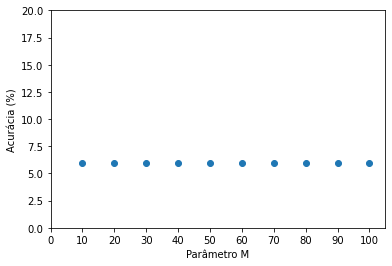

In [111]:
#Plot da acurácia por número de componentes principais
x_plot = x_list_M
plt.scatter(x_plot,y_list_acc)
plt.ylabel("Acurácia (%)")
plt.xlabel("Parâmetro M")
plt.xticks(np.arange(0, 110, step=10));
plt.xlim(0, 105)
plt.ylim(0, 20)
plt.show()

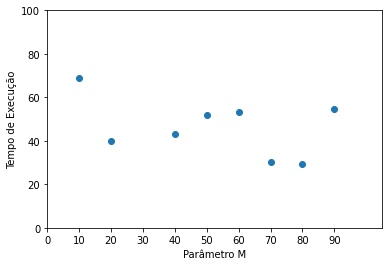

In [115]:
#Plot de tempo de execução por número de componentes principais
x_plot = x_list_M
plt.scatter(x_plot,y_list_time)
plt.ylabel("Tempo de Execução")
plt.xlabel("Parâmetro M")
plt.xticks(np.arange(0, 100, step=10));
plt.xlim(0, 105)
plt.ylim(0, 100)
plt.show()

## 3.3. Acurácia e Tempo de Execução em função da tolerância

### Imputação inicial nula

In [116]:
M = 1
start = time.perf_counter()
data_soft_imp_rand = SoftIMP_np(data_train_rand, train_tuples_rand, M, 2);
print(acc_test(data_rand, data_soft_imp_rand, test_tuples_rand))
end = time.perf_counter()
print(end-start)

5.925
29.737457799999902


In [117]:
M = 1
start = time.perf_counter()
data_soft_imp_rand = SoftIMP_np(data_train_rand, train_tuples_rand, M, 3);
print(acc_test(data_rand, data_soft_imp_rand, test_tuples_rand))
end = time.perf_counter()
print(end-start)

5.925
41.25348289999965


In [118]:
M = 1
start = time.perf_counter()
data_soft_imp_rand = SoftIMP_np(data_train_rand, train_tuples_rand, M, 4);
print(acc_test(data_rand, data_soft_imp_rand, test_tuples_rand))
end = time.perf_counter()
print(end-start)

5.925
130.35683880000033


In [119]:
y_list_tol = list()
y_list_time_tol = list()
x_list_tol = list()

start = time.perf_counter()
i = 1
while i < 5:
    x_list_tol.append(i)
    ping = time.perf_counter()
    data_soft_imp_rand = SoftIMP_np(data_train_rand, train_tuples_rand, 1, i);
    pong = time.perf_counter()
    y_list_tol.append(acc_test(data_rand, data_soft_imp_rand, test_tuples_rand))
    y_list_time_tol.append(pong-ping)
    i+=1
end = time.perf_counter()
print(end-start)

222.7784702000008


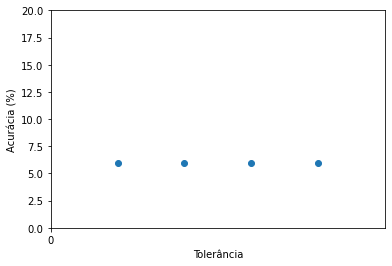

In [126]:
#Plot de tempo de execução por número de componentes principais
x_plot = x_list_tol
plt.scatter(x_plot,y_list_tol)
plt.ylabel("Acurácia (%)")
plt.xlabel("Tolerância")
plt.xticks(np.arange(0, 100, step=10));
plt.xlim(0, 5)
plt.ylim(0, 20)
plt.show()

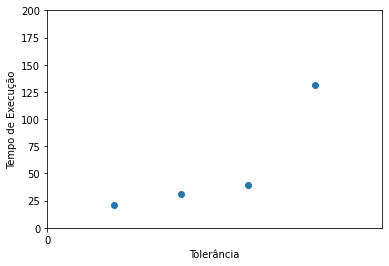

In [122]:
#Plot de tempo de execução por número de componentes principais
x_plot = x_list_tol
plt.scatter(x_plot,y_list_time_tol)
plt.ylabel("Tempo de Execução")
plt.xlabel("Tolerância")
plt.xticks(np.arange(0, 100, step=10));
plt.xlim(0, 5)
plt.ylim(0, 200)
plt.show()

## 3.4. Teste com SVD implementado e Comparação

Se redefinimos a função de imputação com o SVD implementado, aparece um aviso a respeito do SVD, como se algum autovalor da matriz de covariância não fosse um número não-negativo. Corrigimos isso na implementação do SVD, adicionando um 'abs()' no argumento da raíz quadrada. Isso pode ser feito visto que nós sabemos de antemão que os autovalores da matriz de covariância devem necessariamente serem não-negativos.

In [105]:
#Função de imputação. 'm' é o número de componentes principais e 'dec' é o número de casas decimais de tolerância que queremos impor. Por exemplo,
#tol = 5 será equivalente a uma tolerância de 10^-5 sob a condição de convergência
def SoftIMP_SVD2(data, key, m, dec):

    #Transforma dados em array do numpy
    data_buff = np.array(data)

    #Converte valores np.nan vazios em 0.0
    i = 0
    while i < len(data):
            j=0;
            while j < len(data_buff[0]):
                if np.isnan(data_buff[i][j]):
                    data_buff[i][j] = 0.0
                j+=1
            i+=1

    data_imp_old = data_buff
    
    #Definição da tolerância de convergência
    tol = 0.1 ** dec
    
    #Parte iterativa do algoritmo, calculando o valor inicial da objetiva
    obj_old = 0.0
    obj_new = 1.0
    while abs(obj_new - obj_old) > tol:

        #Atualiza o valor da objetiva antiga pela nova do passo anterior
        obj_old = obj_new
        
        #Calcula a matriz de covariância da matriz imputada
        cov_data = np.matmul(data_imp_old.transpose(),data_imp_old)
    
        #Calcula o SVD da matriz de covariância
        cov_data_svd = SVD(cov_data)
    
        #Para o cálculo dos novos valores imputados, multiplicamos as M primeiras colunas linha da matriz imputada às M primeiras linhas da matriz V 
        #do SVD
        data_trsp = data_imp_old.transpose()
        data_trsp_m = data_trsp[:m]
        data_orig_m = data_trsp_m.transpose()
        cov_data_svd_m = cov_data_svd[2][:m]
        data_imp_new = np.matmul(data_orig_m, cov_data_svd_m)

        #Como nos estágios intermediários, a matriz de ratings passa a ter valores imputados fora do intervalo 1 e 5, precisamos retornar as entradas
        #ao intervalo 1 e 5
        data_imp_new_clip = np.clip(data_imp_new, 1, 5)
        data_imp_new = data_imp_new_clip
        
        #Teste de convergência para a nova matriz imputada
        obj_new = SoftIMP_obj(data_imp_old, data_imp_new, key)
        
        #Substituo os valores conhecidos de volta à matriz imputada
        i = 0
        while i < len(key):
           data_imp_new[key[i][0]][key[i][1]] = data_buff[key[i][0]][key[i][1]]
           i+=1

        #Atualizo a matriz antiga para a nova
        data_imp_old = data_imp_new

    #Após convergir, converte entradas para o inteiro mais próximo
    k = 0
    while k < len(data_imp_new):
        l = 0
        while l < len(data_imp_new[0]):
            data_imp_new[k][l] = round(data_imp_new[k][l])*1.0
            l+=1
        k+=1
    data_imp_new_clip = np.clip(data_imp_new, 1, 5)
    return data_imp_new_clip

In [106]:
M = 10
start = time.perf_counter()
data_soft_imp_rand = SoftIMP_SVD2(data_train_rand, train_tuples_rand, M, 1);
print(acc_test(data_rand, data_soft_imp_rand, test_tuples_rand))
end = time.perf_counter()
print(end-start)

5.925
11.96046970000134


Como podemos ver, o resultado da acurácia é idêntico ao caso do SVD do sklearn. O tempo de execução tem a mesma ordem também, pelo menos para $M=10$.

# 4. Conclusões

Conseguimos implementar uma função SVD que encontra a decomposição correta da matriz num tempo de execução comparável à implementação pronta do sklearn. Além disso, tentamos uma implementação do algoritmo SoftImpute, mas não conseguimos boa acurácia: acertamos em torno de $6\%$ das imputações. Além disso, o algoritmo ficou bem insensível a mudanças no parâmetro $M$ e na tolerância de convergência (podemos também não ter explorado bem o suficiente o espaço de possibilidades). Em contrapartida, o tempo de execução é bastante sensível a ambos, em especial à tolerância exigida.

Procurando outras implementações de SoftImpute na internet, notamos também que o nosso teste de acurácia ficaria melhor expresso em termos do RMSE (<i>Root Mean-Squared Error</i>).